# **CROP RECOMMENDATION SYSTEM**

## **Imports & Dataset Loading**

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.patches as mpatches


## **Load Dataset + EDA**

In [34]:
crop = pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")

print(crop.shape)
print(crop.info())
print(crop.isnull().sum())
print(crop.duplicated().sum())
print(crop.describe())




(2200, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
None
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
0
                 N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    

In [35]:
#  Correlation Heatmap (Only numerical features)
feature_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
corr = crop[feature_cols].corr()
fig = go.Figure(data=go.Heatmap(z=corr.values, x=corr.columns, y=corr.columns, colorscale='Blues'))
fig.update_layout(title='Feature Correlation Heatmap')
fig.show()



## **Label Encoding + Visualization**

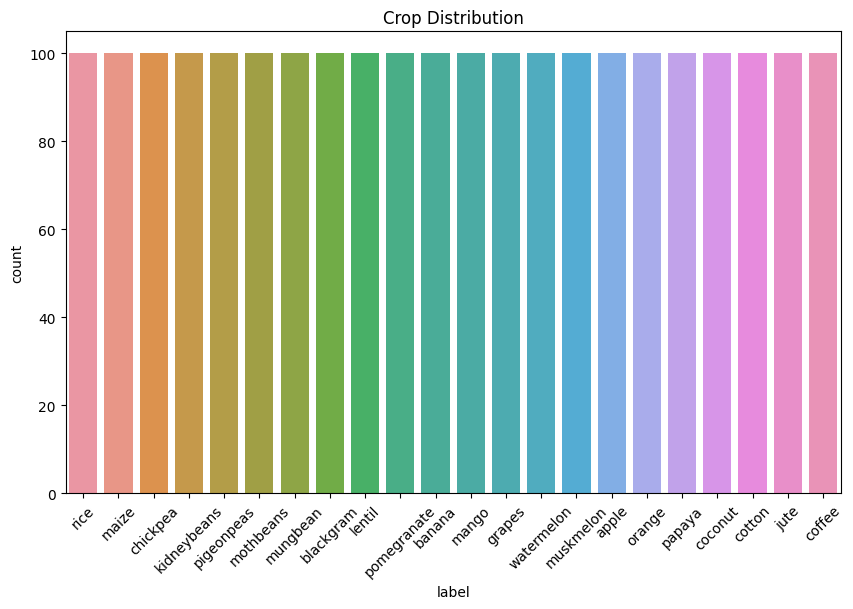

In [36]:

crop_dict = {
    'rice': 1, 'maize': 2, 'jute': 3, 'cotton': 4, 'coconut': 5, 'papaya': 6, 'orange': 7, 'apple': 8,
    'muskmelon': 9, 'watermelon': 10, 'grapes': 11, 'mango': 12, 'banana': 13, 'pomegranate': 14,
    'lentil': 15, 'blackgram': 16, 'mungbean': 17, 'mothbeans': 18, 'pigeonpeas': 19,
    'kidneybeans': 20, 'chickpea': 21, 'coffee': 22
}
crop['crop_num'] = crop['label'].map(crop_dict)
crop_reverse_dict = {v: k.capitalize() for k, v in crop_dict.items()}

# Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=crop)
plt.xticks(rotation=45)
plt.title("Crop Distribution")
plt.show()



## **Feature Setup**


In [37]:
X = crop.drop(['label', 'crop_num'], axis=1)
y = crop['crop_num']


## **SVM Model (with scaling)**

In [38]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train_svm = sc.fit_transform(X_train_svm)
X_test_svm = sc.transform(X_test_svm)



In [39]:
svm = SVC(kernel='rbf', probability=True)
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]}


In [40]:
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train_svm, y_train_svm)


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1]})

In [41]:
best_svm = grid_search.best_estimator_
best_svm

SVC(C=10, gamma=0.1, probability=True)

In [42]:

yhat_svm = best_svm.predict(X_test_svm)
print("SVM Accuracy:", accuracy_score(y_test_svm, yhat_svm))
print(classification_report(y_test_svm, yhat_svm))


SVM Accuracy: 0.9772727272727273
              precision    recall  f1-score   support

           1       0.94      0.84      0.89        19
           2       1.00      1.00      1.00        21
           3       0.88      0.96      0.92        23
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        23
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        23
          15       0.79      1.00      0.88        11
          16       0.95      0.95      0.95        20
          17       1.00      1.00      1.00     

## **SVM Confusion Matrix**

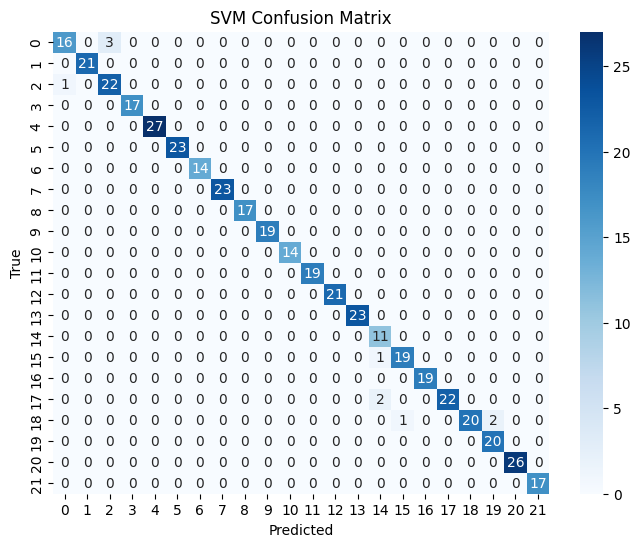

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_svm, yhat_svm), annot=True, fmt='d', cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

svm_cv = cross_val_score(best_svm, X_train_svm, y_train_svm, cv=5).mean()


## **PCA Visualization**

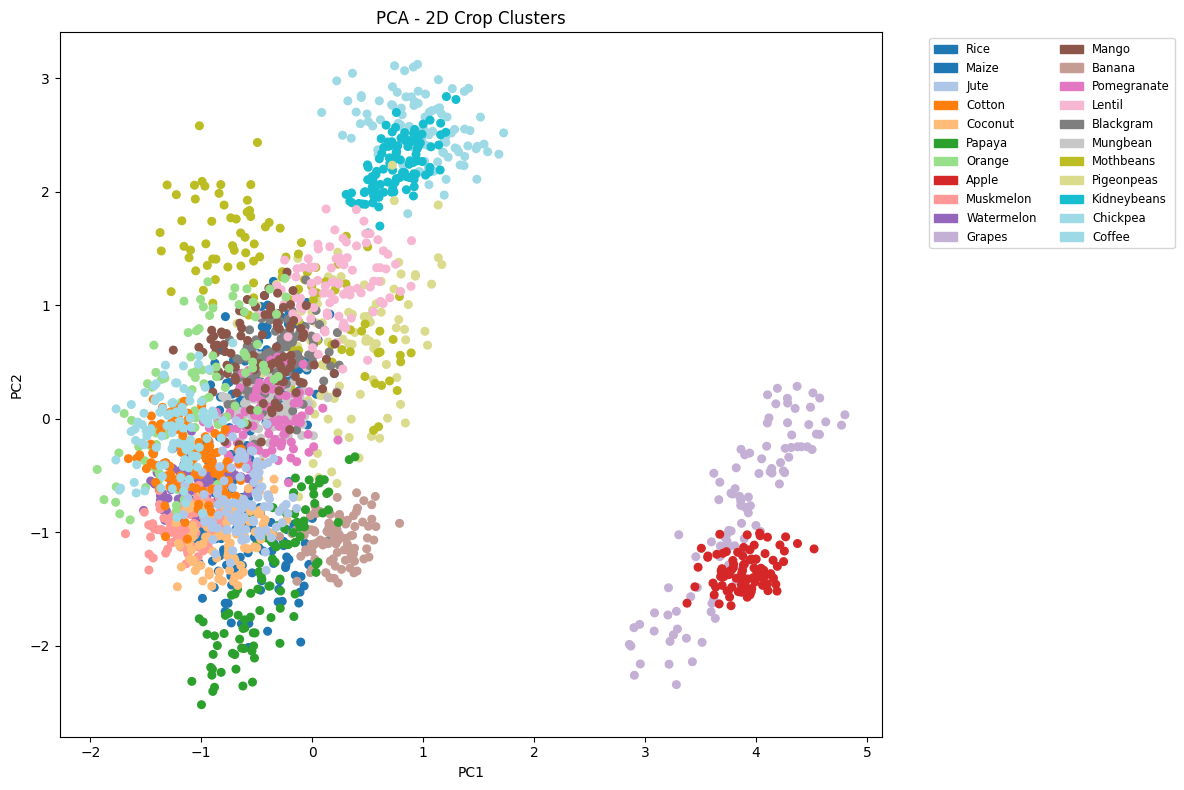

In [44]:
X_scaled = sc.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
y_encoded = LabelEncoder().fit_transform(y)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(y_encoded))))
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap=ListedColormap(colors), s=30)

handles = [mpatches.Patch(color=colors[i], label=crop_reverse_dict[i+1]) for i in range(len(colors))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize='small')
plt.title("PCA - 2D Crop Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## **Random Forest Model**

In [45]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train_rf)
yhat_rf = rf.predict(X_test_rf)

print("RF Accuracy:", accuracy_score(y_test_rf, yhat_rf))
print(classification_report(y_test_rf, yhat_rf))


RF Accuracy: 0.9931818181818182
              precision    recall  f1-score   support

           1       1.00      0.89      0.94        19
           2       1.00      1.00      1.00        21
           3       0.92      1.00      0.96        23
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        23
           7       1.00      1.00      1.00        14
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00        21
          14       1.00      1.00      1.00        23
          15       0.92      1.00      0.96        11
          16       1.00      1.00      1.00        20
          17       1.00      1.00      1.00      

## **Random Forest Confusion Matrix**

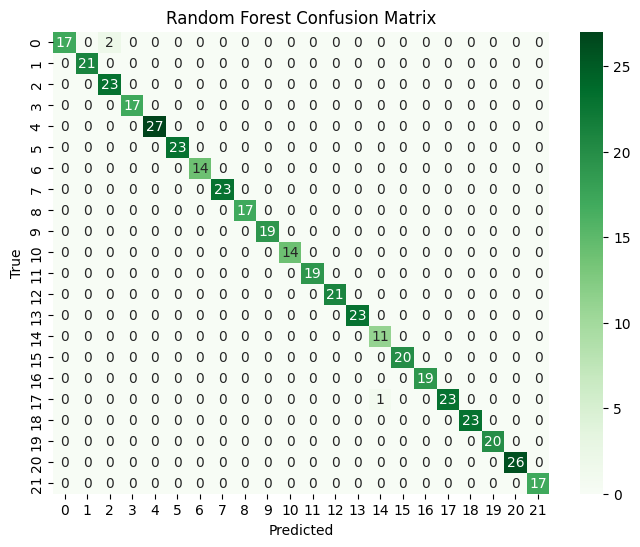

In [46]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_rf, yhat_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

rf_cv = cross_val_score(rf, X_train_rf, y_train_rf, cv=5).mean()

## **Model Comparision**

In [47]:
summary_df = pd.DataFrame({
    "Model": ["SVM", "Random Forest"],
    "Test Accuracy": [accuracy_score(y_test_svm, yhat_svm), accuracy_score(y_test_rf, yhat_rf)],
    "Cross-Validation Accuracy": [svm_cv, rf_cv]
}).round(4)

print("Model Comparison Summary:")
print(summary_df.to_string(index=False))


Model Comparison Summary:
        Model  Test Accuracy  Cross-Validation Accuracy
          SVM         0.9773                     0.9875
Random Forest         0.9932                     0.9955


## **Final recommendation function**

In [48]:
def recommend_by_confidence(svm_model, rf_model, scaler, N, P, K, temperature, humidity, ph, rainfall, reverse_dict):
    feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    input_df = pd.DataFrame([[N, P, K, temperature, humidity, ph, rainfall]], columns=feature_names)

    scaled_input = scaler.transform(input_df)
    svm_probs = svm_model.predict_proba(scaled_input)
    svm_index = np.argmax(svm_probs)
    svm_conf = np.max(svm_probs)
    svm_crop = reverse_dict.get(svm_index + 1, "Unknown")

    rf_probs = rf_model.predict_proba(input_df)
    rf_index = np.argmax(rf_probs)
    rf_conf = np.max(rf_probs)
    rf_crop = reverse_dict.get(rf_index + 1, "Unknown")

    print(f"SVM predicts: {svm_crop} with confidence {svm_conf:.4f}")
    print(f"Random Forest predicts: {rf_crop} with confidence {rf_conf:.4f}")

    if svm_conf > rf_conf:
        final_crop = svm_crop
        model_used = "SVM"
    else:
        final_crop = rf_crop
        model_used = "Random Forest"

    print(f"\nFinal Recommended Crop: {final_crop} (by {model_used})")
    return final_crop


## **Sample prediction**

In [49]:
recommend_by_confidence(
    best_svm, rf, sc,
    N=74, P=34, K=26, temperature=25, humidity=67.1, ph=6.98, rainfall=202.8,

    reverse_dict=crop_reverse_dict
)


SVM predicts: Coffee with confidence 0.4622
Random Forest predicts: Coffee with confidence 0.8200

Final Recommended Crop: Coffee (by Random Forest)


'Coffee'

## **Actual vs Predicted Comparision**

In [50]:
##  Recommendation comparison for 5 random test samples

def detailed_recommendation_display(samples_df, actual_labels, svm_model, rf_model, scaler, reverse_dict):
    results = []

    for idx, row in samples_df.iterrows():
        input_data = pd.DataFrame([row], columns=row.index)

        scaled_data = scaler.transform(input_data)

        # SVM
        svm_probs = svm_model.predict_proba(scaled_data)
        svm_index = np.argmax(svm_probs)
        svm_conf = np.max(svm_probs)
        svm_crop = reverse_dict.get(svm_index + 1, "Unknown")

        # RF
        rf_probs = rf_model.predict_proba(input_data)
        rf_index = np.argmax(rf_probs)
        rf_conf = np.max(rf_probs)
        rf_crop = reverse_dict.get(rf_index + 1, "Unknown")

        # Final decision
        if svm_conf > rf_conf:
            final_crop = svm_crop
            model_used = "SVM"
        else:
            final_crop = rf_crop
            model_used = "Random Forest"

        results.append({
            " Actual Crop": reverse_dict.get(actual_labels.loc[idx], "Unknown"),
            " SVM Prediction": svm_crop,
            " RF Prediction": rf_crop,
            " Final Recommendation": final_crop,
            " Model Used": model_used
        })

    return pd.DataFrame(results)

# Select 5 random samples from test set
sample_indices = np.random.choice(X_test_rf.index, 5, replace=False)
sample_data = X.loc[sample_indices]
actual_labels = y.loc[sample_indices]

# Display the comparison as a styled table
recommendation_df = detailed_recommendation_display(
    sample_data, actual_labels, best_svm, rf, sc, crop_reverse_dict
)

# Display nicely
print(" Model Predictions vs Actual Crops:\n")
recommendation_df.reset_index(drop=True).style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]}]
).set_properties(**{'text-align': 'center'})


 Model Predictions vs Actual Crops:



,Actual Crop,SVM Prediction,RF Prediction,Final Recommendation,Model Used
0,Rice,Rice,Rice,Rice,Random Forest
1,Mungbean,Mungbean,Mungbean,Mungbean,Random Forest
2,Papaya,Papaya,Papaya,Papaya,Random Forest
3,Orange,Orange,Orange,Orange,Random Forest
4,Maize,Maize,Maize,Maize,Random Forest


## **SHAP Explainability for Random Forest Model**

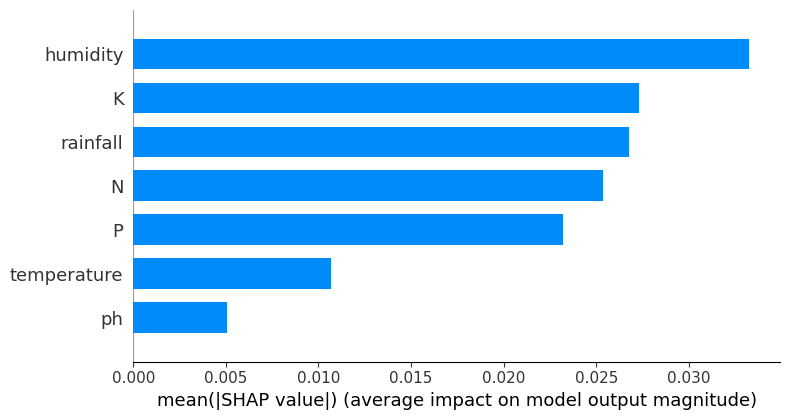

In [51]:
import shap

# Ensure SHAP works cleanly in notebook
shap.initjs()

# TreeExplainer for RF model
explainer_rf = shap.TreeExplainer(rf)

# Compute SHAP values (multi-class array: [n_classes][n_samples][n_features])
shap_values_rf = explainer_rf.shap_values(X_train_rf)

# ---------- GLOBAL FEATURE IMPORTANCE ----------
# Use mean absolute SHAP values across all classes for better visualization
mean_shap_values = np.mean([np.abs(vals) for vals in shap_values_rf], axis=0)

# Plot bar summary (cleaned, top 7 important features only)
shap.summary_plot(mean_shap_values, X_train_rf, plot_type="bar", max_display=7)


## **SHAP Force Plot: Local Prediction Explanation**

In [52]:
# ---------- LOCAL EXPLANATION (FORCE PLOT) ----------
sample_idx = 6  # Change this to view different samples
sample_data = X_train_rf.iloc[[sample_idx]]
predicted_class = rf.predict(sample_data)[0] - 1  # Adjust for 1-based indexing

# SHAP force plot for predicted class only
shap.force_plot(
    explainer_rf.expected_value[predicted_class],
    shap_values_rf[predicted_class][sample_idx],
    sample_data
)


## **LIME Explanation: SVM Prediction Insights**

In [53]:
import lime
import lime.lime_tabular

# LIME explainer for tabular data
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_svm,                  # scaled training data
    feature_names=X.columns.tolist(),           # original column names
    class_names=list(crop_reverse_dict.values()),
    mode='classification'
)

# Choose a test instance to explain
sample_idx = 5 # can change to 1, 2, ...
sample_data_scaled = X_test_svm[sample_idx]
sample_data_original = X_test_rf.iloc[sample_idx]  # original values (unscaled) for readability

# Explain prediction for that instance
lime_exp = lime_explainer.explain_instance(
    data_row=sample_data_scaled,
    predict_fn=best_svm.predict_proba,
    num_features=7
)

# Show explanation in notebook
lime_exp.show_in_notebook(show_table=True, show_all=False)
